# 1. Gaussian Process 

$t_n = y(x_n) + \epsilon_n, \quad \epsilon_n \sim N(0, \beta^{-1}) \\
k(x_n, x_m) = \theta_0 exp\{-\frac{\theta_1}{2}||x_n-x_m||^2\} +\theta_2+\theta_3x_n^Tx_m \\
C(x_n, x_m) = k(x_n, x_m) + \beta^{-1}\delta_{nm} \\
m(x_{N+1}) = k^TC_N^{-1}t \\
\sigma^2(x_{N+1}) = k(x_{N+1}, x_{N+1}) + \beta^{-1} - k^TC_N^{-1}k \\
E_{RMS} = \sqrt{\frac{1}{N}(m(x_n)-t_n)^2}$

In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

upload = files.upload()
x = pd.read_csv("gp_x.csv", header=None)
t = pd.read_csv("gp_t.csv", header=None)

x = x.to_numpy()
t = t.to_numpy()

#print(x.shape)
#print(t.shape)

Saving gp_t.csv to gp_t.csv
Saving gp_x.csv to gp_x.csv


In [2]:
def exp_quad_kernel(xn, xm, t0, t1, t2, t3):
  #print(t0, t1, t2, t3)
  a = t0 * np.exp(-t1/2 * np.dot((xn-xm).transpose(), xn-xm))
  a = a + t2 + t3 * np.dot(xn.transpose(), xm)
  return a

def RMS(y, t):
  a = (y - t)**2 / 50
  return np.sqrt(np.sum(a))

def calculate_cov(x, theta):
  C = np.zeros([50, 50])
  for n in range(50):
    for m in range(50):
      C[n][m] = exp_quad_kernel(x[n], x[m], *theta) + (n == m)
  return C

def gaussian_process(x, t, theta, test_x):
  # calculate cov
  C = calculate_cov(x, theta)
  # calculate k
  k = np.zeros([50, 1])
  for n in range(50):
    k[n] = exp_quad_kernel(x[n], test_x, *theta)

  mean = np.dot(np.dot(k.transpose(), np.linalg.inv(C)), t)
  var = exp_quad_kernel(test_x, test_x, *theta) + 1 - np.dot(np.dot(k.transpose(), np.linalg.inv(C)), k)
  stdev = np.sqrt(var)
  return mean, stdev


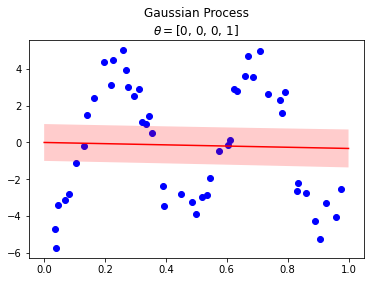

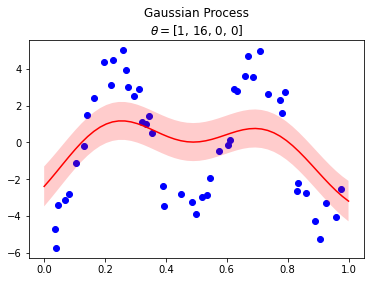

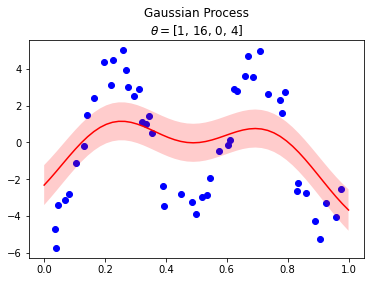

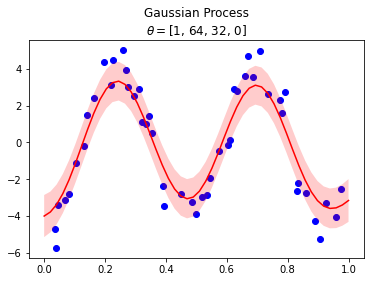

In [3]:
train_x = x[:50, :]
train_t = t[:50, :]
test_x = x[50:, :]
test_t = t[50:, :]
#print(train_x.shape)
theta_list = [[0, 0, 0, 1], [1, 16, 0, 0], [1, 16, 0, 4], [1, 64, 32, 0]]
plotx = np.linspace(0, 1)
mean_list = np.empty([50])
stdev_list = np.empty([50])

for i in range(4):
  for j in range(50):
    mean, stdev = gaussian_process(train_x, train_t, theta_list[i], plotx[j])
    mean_list[j] = mean
    stdev_list[j] = stdev

  plt.scatter(train_x, train_t, color='blue')
  plt.fill_between(plotx, mean_list-stdev_list, mean_list+stdev_list, facecolor='red', alpha=0.2)
  plt.plot(plotx, mean_list, color='red')
  plt.title('Gaussian Process\n' + r'$\theta = $' + str(theta_list[i]))
  plt.show()

θ  =  [0, 0, 0, 1]
training RMSE:  3.1292014298222433
testing RMSE:  3.344398660186115
θ  =  [1, 16, 0, 0]
training RMSE:  2.4239279278312194
testing RMSE:  2.668051750252446
θ  =  [1, 16, 0, 4]
training RMSE:  2.4105764871252067
testing RMSE:  2.6569980001669165
θ  =  [1, 64, 32, 0]
training RMSE:  1.0428861621832217
testing RMSE:  1.1627590936118453


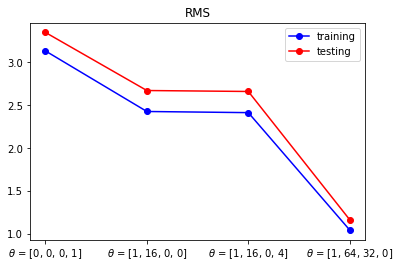

In [4]:
predict_train = np.empty([50, 1])
predict_test = np.empty([50, 1])
train_RMS = []
test_RMS = []

for i in range(4):
  for j in range(50):
    predict_train[j] = gaussian_process(train_x, train_t, theta_list[i], train_x[j])[0]
    predict_test[j] = gaussian_process(train_x, train_t, theta_list[i], test_x[j])[0]
  train_RMS.append(RMS(predict_train, train_t))
  test_RMS.append(RMS(predict_test, test_t))

  print(chr(952), ' = ', theta_list[i])
  print("training RMSE: ", train_RMS[i])
  print("testing RMSE: ", test_RMS[i])

theta_str = [r'$\theta$ = [0, 0, 0, 1]', r'$\theta$ = [1, 16, 0, 0]', r'$\theta$ = [1, 16, 0, 4]', r'$\theta$ = [1, 64, 32, 0]']
plt.plot(theta_str, train_RMS, '-bo', label='training')
plt.plot(theta_str, test_RMS, '-ro', label='testing')
plt.title('RMS')
plt.legend()
plt.show()

$\frac{\partial}{\partial\theta_i}lnp(t|\theta) = -\frac{1}{2}Tr(C_N^{-1}\frac{\partial C_N}{\partial \theta_i})+ \frac{1}{2}t^TC_N^{-1}\frac{\partial C_N}{\partial \theta_i}C_N^{-1}t \\

\frac{\partial C_N}{\partial \theta_0}=exp\{-\frac{\theta_1}{2}||x_n-x_m||^2\}\\

\frac{\partial C_N}{\partial \theta_1} = \theta_0exp\{-\frac{\theta_1}{2}||x_n-x_m||^2\} \times -\frac{1}{2}||x_n-x_m||^2 \\

\frac{\partial C_N}{\partial \theta_2} = 1 \\

\frac{\partial C_N}{\partial \theta_3} = x_n^Tx_m$

In [5]:
def pd_C(x, index, t0, t1, t2, t3):
  c = np.zeros([50, 50])
  if index == 0:
    for n in range(50):
      for m in range(50):
        c[n][m] = np.exp(-t1/2 * np.dot((x[n]-x[m]).transpose(), x[n]-x[m]))
  elif index == 1:
    for n in range(50):
      for m in range(50):
        c[n][m] = t0 * np.exp(-t1/2 * np.dot((x[n]-x[m]).transpose(), x[n]-x[m])) * -1/2 * np.dot((x[n]-x[m]).transpose(), x[n]-x[m])
  elif index == 2:
    c = np.ones([50, 50])
  elif index == 3:
    for n in range(50):
      for m in range(50):
        c[n][m] = np.dot(x[n].transpose(), x[m])
  return c      
def ARD(x, t, learning_rate, iter_time):
  theta_param = np.array([1, 64, 32, 0]).astype(float)
  dln_p = np.zeros(4)
  list0, list1, list2, list3 = [1], [64], [32], [0]
  rms = []
  for i in range(iter_time):
    C_inv = np.linalg.inv(calculate_cov(x, theta_param))
    for j in range(4):
      dc = pd_C(x, j, *theta_param)
      dln_p[j] = -1/2 * np.trace(np.dot(C_inv, dc))
      a = t.transpose().dot(C_inv).dot(dc).dot(C_inv).dot(t)
      dln_p[j] = dln_p[j] + 1/2 * a
    theta_param += dln_p * learning_rate
    list0.append(theta_param[0])
    list1.append(theta_param[1])
    list2.append(theta_param[2])
    list3.append(theta_param[3])
    #print(theta_param)
    predict = np.empty([50, 1])
    for i in range(50):
      predict[i] = gaussian_process(x, t, theta_param, x[i])[0]
    rms.append(RMS(predict, t))
  plt.plot(range(iter_time+1), list0, '-b', label=r'$\theta0$')
  plt.plot(range(iter_time+1), list1, '-r', label=r'$\theta1$')
  plt.plot(range(iter_time+1), list2, '-g', label=r'$\theta2$')
  plt.plot(range(iter_time+1), list3, '-y', label=r'$\theta3$')
  plt.title(r'$\theta$')
  plt.legend()
  plt.show()
  plt.plot(range(iter_time), rms, '-b', label='training')
  plt.title('RMS')
  plt.legend()
  plt.show()

  return theta_param

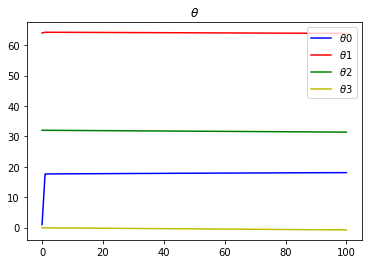

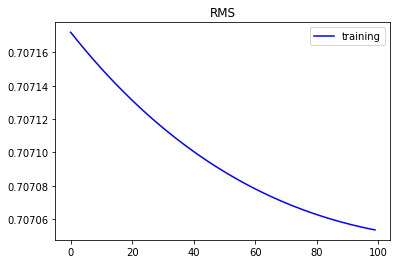

[18.07747448 63.84536278 31.39138562 -0.76028737]


In [6]:
hyper = ARD(train_x, train_t, 0.45, 100)
print(hyper)

# 2. Support Vector Machine

$y(x) = \sum_{n=1}^N\alpha_nt_nk(x, x_n) = w^Tx+b \\ 
w = \sum_{n=1}^N\alpha_nt_n\phi(x_n) \\
b = \frac{1}{N_M}\sum_{n\in M}(t_n - \sum_{m\in S}\alpha_mt_mk(x_n, x_m))$

Linear kernel:

$k(x_i, x_j) = \phi(x_i)^T\phi(x_j) = x_i^Tx_j$

Polynomial (homogeneous) kernel of degree 2:

$k(x_i, x_j) = \phi(x_i)^T\phi(x_j) = (x_i^Tx_j)^2 \\
\phi(x) = [x_1^2, \sqrt2x_1x_2, x_2^2], \quad x = [x_1, x_2]$

In [7]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC

upload = files.upload()
x = pd.read_csv("x_train.csv", header=None)
t = pd.read_csv("t_train.csv", header=None)

x = x.to_numpy()
t = t.to_numpy()
x = x / 255
#print(x.shape)
#print(t.shape)

Saving t_train.csv to t_train.csv
Saving x_train.csv to x_train.csv


In [8]:
def PCA(x, d):
  mean = np.mean(x, axis=0)
  x = x - mean
  s = np.dot(x.transpose(), x) / x.shape[0]
  eig_val, eig_vec = np.linalg.eig(s)
  eig_vec = eig_vec.real
  top_d = np.argsort(-eig_val)[:d]
  return np.dot(x, eig_vec[:,top_d])
def svm(alpha, t, x, s):
  # alpha: 300*1, t: 300*1, x: 300*2
  S = np.where(alpha != 0)[0]
  M = np.where( (alpha > 0) & (alpha < 1) )[0]
  #print(S)
  #print(M)
  if s == 'linear':
    w = np.dot(alpha * t, x)
    '''sum_n = 0
    for n in M:
      sum_m = 0
      for m in S:
        sum_m += alpha[m] * t[m] * np.dot(x[n], x[m].transpose())
      sum_n += t[n] - sum_m
    b = sum_n / M.shape[0]'''
    k = np.dot(x[M], x[S].transpose())
    b = np.sum(t[M] - np.dot((alpha*t)[S], k.transpose()))
    b = b / M.shape[0]
    return w, b
  elif s == 'poly':
    phi = np.zeros([x.shape[0], 3])
    for i in range(x.shape[0]):
      phi[i] = [x[i, 0]**2, np.sqrt(2)*x[i, 0]*x[i, 1], x[i, 1]**2]
    w = np.dot(alpha * t, phi)
    k = np.dot(phi[M], phi[S].transpose())
    b = np.sum(t[M] - np.dot((alpha*t)[S], k.transpose()))
    b = b / M.shape[0]
    return w, b

def predict(phi, w_list, b_list):
  c = [(0, 1), (0, 2), (1, 2)]
  result = []
  #print(w_list)
  #print(b_list)
  for i in range(phi.shape[0]):
    a = [0, 0, 0]
    for j in range(3):
      y = np.dot(w_list[j], phi[i].transpose()) + b_list[j]
      #print(y)
      if y > 0:
        a[c[j][0]] += 1
      elif y < 0:
        a[c[j][1]] += 1
    #print(a)
    result.append(np.argmax(a))
  return np.array(result)

In [9]:
train_x = PCA(x, 2)
clf = SVC(kernel='linear', decision_function_shape='ovo')
clf.fit(train_x, t.flatten())
coefficient = np.abs(clf.dual_coef_)
index = clf.support_
lm = np.zeros([300, 2])
lm[index] = coefficient.transpose()
#print(lm.shape)

# [0] -> 0 v.s 1, [1] -> 0 v.s. 2, [2] -> 1 v.s. 2
target_list = [np.repeat([1, -1, 0], 100), np.repeat([1, 0, -1], 100), np.repeat([0, 1, -1], 100)]
lm_list = [np.concatenate((lm[0:200, 0], np.tile(0, 100))), \
       np.concatenate((lm[0:100, 1], np.tile(0, 100), lm[200:300, 0])), \
       np.concatenate((np.tile(0, 100), lm[100:300, 1]))]
#print(lm_list[0].shape)

w_list = []
b_list = []
for i in range(3):
  w, b = svm(lm_list[i], target_list[i], train_x, 'linear')
  w_list.append(w)
  b_list.append(b)
  #print(w, b)

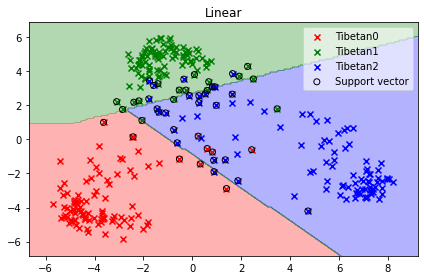

In [10]:
class_color = ['red', 'green', 'blue']
x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

phi = np.dstack((xx, yy)).reshape(xx.shape[0]*xx.shape[1], 2)
z = predict(phi, w_list, b_list)
z = z.reshape(xx.shape)

cmap = matplotlib.colors.ListedColormap(class_color)
plt.contourf(xx, yy, z, cmap=cmap, levels=3, alpha=0.3)
plt.title("Linear")
for i in range(3):
  plt.scatter(train_x[i*100:(i+1)*100, 0], train_x[i*100:(i+1)*100, 1], color=class_color[i], marker='x', label='Tibetan'+str(i))
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], edgecolors='black', facecolors='none', label='Support vector')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(framealpha=0.6)
plt.tight_layout()
plt.show()


In [11]:
clf = SVC(kernel='poly', degree=2, decision_function_shape='ovo')
clf.fit(train_x, t.flatten())
coefficient = np.abs(clf.dual_coef_)
index = clf.support_
lm = np.zeros([300, 2])
lm[index] = coefficient.transpose()
#print(lm.shape)

# [0] -> 0 v.s 1, [1] -> 0 v.s. 2, [2] -> 1 v.s. 2
lm_list = [np.concatenate((lm[0:200, 0], np.tile(0, 100))), \
       np.concatenate((lm[0:100, 1], np.tile(0, 100), lm[200:300, 0])), \
       np.concatenate((np.tile(0, 100), lm[100:300, 1]))]

w_list = []
b_list = []
for i in range(3):
  w, b = svm(lm_list[i], target_list[i], train_x, 'poly')
  w_list.append(w)
  b_list.append(b)
  #print(w, b)

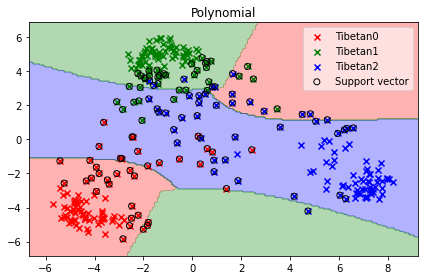

In [12]:
b = np.dstack((xx, yy)).reshape(xx.shape[0]*xx.shape[1], 2)
phi = np.zeros([b.shape[0], 3])
for i in range(b.shape[0]):
  phi[i] = [b[i, 0]**2, np.sqrt(2)*b[i, 0]*b[i, 1], b[i, 1]**2]

z = predict(phi, w_list, b_list)
z = z.reshape(xx.shape)

cmap = matplotlib.colors.ListedColormap(class_color)
plt.contourf(xx, yy, z, cmap=cmap, levels=3, alpha=0.3)
plt.title("Polynomial")
for i in range(3):
  plt.scatter(train_x[i*100:(i+1)*100, 0], train_x[i*100:(i+1)*100, 1], color=class_color[i], marker='x', label='Tibetan'+str(i))
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], edgecolors='black', facecolors='none', label='Support vector')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(framealpha=0.6)
plt.tight_layout()
plt.show()

# 3. Gaussian Mixture Model

In [13]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

upload = files.upload()
img = mpimg.imread("imghw3.jpg")
#print(img.shape)
#plt.imshow(img)
img = img / 255
img = img.reshape(img.shape[0]*img.shape[1], 3)

Saving imghw3.jpg to imghw3.jpg


$J = \sum_{n=1}^N\sum_{k=1}^K\gamma_{nk}||x_n-\mu_k||^2 \\

\gamma_{nk} = \left\{
\begin{array}{lr}
1\quad if\quad k = arg min_j||x_n-\mu_j||^2 \\
0\quad otherwise
\end{array}
\right. \\

\mu_k = \frac{\sum_n\gamma_{nk}x_n}{\sum_n\gamma_{nk}}$


In [14]:
def k_means(x, k, iter_time):
  rand = np.random.choice(x.shape[0], k, replace=False)
  mu = x[rand]
  r = np.zeros([x.shape[0], k])
  J = np.empty([x.shape[0], k])
  for i in range(iter_time):
    # J[:,j] -> distance between x and mu[j]
    for j in range(k):
      J[:, j] = np.sum((x - mu[j])**2, axis=1)
    
    new_r = np.zeros([x.shape[0], k])
    new_r[np.arange(x.shape[0]), np.argmin(J, axis=1)] = 1
    
    if np.array_equal(r, new_r):
      break
    else:
      r = new_r
    for j in range(k):
      mu[j] = np.sum(r[:, j].reshape(x.shape[0], 1)*x, axis=0) / np.sum(r[:, j])
  return mu, r

$p(x) = \sum_{k=1}^K\pi_kN(x|\mu_k, \Sigma_k) \\
lnp(X|\pi,\mu,\Sigma) = \sum_{n=1}^Nln\{\sum_{k=1}^K\pi_kN(x_n|\mu_k, \Sigma_k)\} \\

\gamma(z_{nk}) = \frac{\pi_kN(x|\mu_k, \Sigma_k}{\sum_{j=1}^K\pi_jN(x_n|\mu_j, \Sigma_j)} \\

\mu_k^{new} = \frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})x_n \\

\Sigma_k^{new} = \frac{1}{N_k}\sum_{n=1}^N\gamma(z_{nk})(x_n-\mu_k^{new})(x_n-\mu_k^{new})^T \\
\pi_k^{new} = \frac{N_k}{N}\quad where\quad N_k = \sum_{n=1}^N\gamma(z_{nk})
$

In [15]:
def multivariate_gaussian(x, mean, cov):
  # mean: 1*3
  # cov: 3*3
  a = -1/2 * np.sum((x-mean).dot(np.linalg.inv(cov)) * (x-mean), axis=1)
  a = np.exp(a)
  a = 1/((2*np.pi)**(3/2)) * 1/np.sqrt(np.linalg.det(cov)) * a
  return a

def GMM(x, k, mu, r):
  cov = np.zeros([k, 3, 3])
  pi = np.zeros([k, 1])
  prob = np.zeros([x.shape[0], k])
  gamma = np.zeros([x.shape[0], k])
  likelihood = []
  
  for i in range(k):
  #  cov[i] = np.cov(x[np.where(r[:, i] == 1)[0]].transpose())
    var = np.var(x[np.where(r[:, i] == 1)], axis=0)
    cov[i] = var * np.identity(3)
  pi = np.sum(r, axis=0) / r.shape[0]

  # normal distribution
  for i in range(k):
    prob[:, i] = pi[i] * multivariate_gaussian(x, mu[i], cov[i]).reshape(x.shape[0])
  likelihood.append(np.sum(np.log(np.sum(prob, axis=1))))

  for i in range(100):
    # E step
    for j in range(k):
      gamma[:, j] = prob[:, j] / np.sum(prob, axis=1)

    # M step
    Nk = np.sum(gamma, axis=0)
    for j in range(k):
      mu[j] = np.sum(gamma[:, j].reshape(x.shape[0], 1) * x, axis=0) / Nk[j]

    for j in range(k):
      cov[j] = np.zeros([3, 3])
      for l in range(x.shape[0]):
        cov[j] += gamma[l, j] * np.dot((x[l]-mu[j]).reshape(1, 3).transpose(), (x[l]-mu[j]).reshape(1, 3))
      cov[j] = cov[j] / Nk[j]
    pi = Nk / x.shape[0]

    # calculate log likelihood
    for j in range(k):
      prob[:, j] = pi[j] * multivariate_gaussian(x, mu[j], cov[j]).reshape(x.shape[0])
    likelihood.append(np.sum(np.log(np.sum(prob, axis=1))))
  return likelihood, mu, prob

def new_image(mu, r, prob, s):
  new_img = np.empty([76480, 3])
  if s == 'k_means':
    new_img = mu[np.where(r == 1)[1]] * 255
  elif s == 'GMM':
    new_img = mu[np.argmax(prob, axis=1)] * 255
  new_img = new_img.astype(int)
  new_img = new_img.reshape(239, 320, 3)
  return new_img

K = 3
μ	R			G			B			
μ1	0.761192021736674	0.7677322406758785	0.715392142301796	
μ2	0.290018164626188	0.26118244252007256	0.20722649004215107	
μ3	0.5217357735557767	0.49432284380835484	0.40901191469454456	


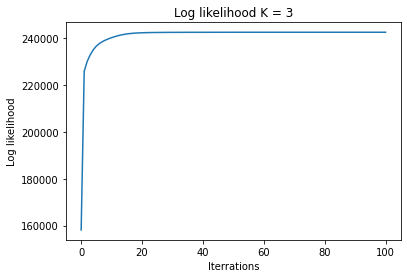

K = 5
μ	R			G			B			
μ1	0.6638807114458376	0.6586665880322647	0.5798164867083283	
μ2	0.5223620571776519	0.49150460442460675	0.4041488355995481	
μ3	0.2324997343110883	0.20403227234881768	0.15670665285081822	
μ4	0.36720023956685083	0.33833527758026616	0.2738288258088042	
μ5	0.8386336955164803	0.8521006619208816	0.8245372798801369	


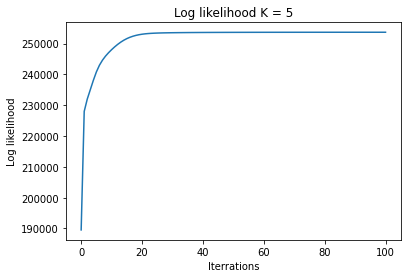

K = 7
μ	R			G			B			
μ1	0.6424765180732316	0.6791847630960137	0.6800974022213605	
μ2	0.8617470092730664	0.8732734008164507	0.848321968177588	
μ3	0.7408853100404766	0.6858559665165086	0.4819488042703486	
μ4	0.5465327047385473	0.5187340625819066	0.444675377836766	
μ5	0.20297526846320507	0.17604889097580648	0.12862737901841367	
μ6	0.4330961912903009	0.4037751908496552	0.32261888172900133	
μ7	0.3146372626235648	0.2847159719755175	0.23219124982623932	


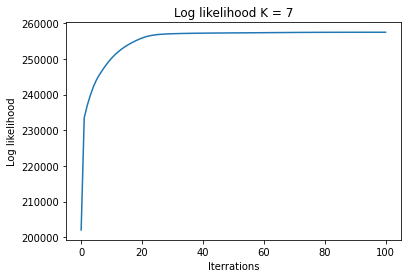

K = 10
μ	R			G			B			
μ1	0.4678961645286156	0.42556728735954885	0.32510401919361337	
μ2	0.5956623406991209	0.6245686068183349	0.6174936898645444	
μ3	0.3566473175615533	0.3297964969120539	0.27309265071496075	
μ4	0.9067401113866618	0.9163922652682567	0.9003103107172553	
μ5	0.46544249420199085	0.4881812671305126	0.48012663398694694	
μ6	0.6087093550058121	0.5460722302067218	0.40521141111786574	
μ7	0.1748785300283706	0.1491484770008582	0.10098162535454382	
μ8	0.7811531395989074	0.7243988726988997	0.5100633970574513	
μ9	0.7394926712634458	0.7678983658727775	0.7556403067882193	
μ10	0.2745872891586355	0.2440105271170924	0.19519292464626248	


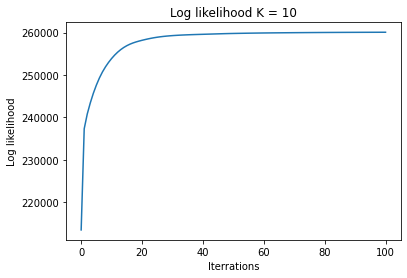

In [16]:
k_list = [3, 5, 7, 10]
k_means_img_list = []
GMM_img_list = []
for i in k_list:
  mu, r = k_means(img, i, 300)
  k_means_img_list.append(new_image(mu, r, 0, 'k_means'))
  print('K = ' + str(i))
  print(chr(956) + '\tR\t\t\tG\t\t\tB\t\t\t')
  for j in range(i):
    print(chr(956) + str(j+1)+'\t' + str(mu[j,0])+'\t' + str(mu[j,1])+'\t' + str(mu[j,2])+'\t')
  likelihood, mu, prob = GMM(img, i, mu, r)
  GMM_img_list.append(new_image(mu, 0, prob, 'GMM'))
  plt.plot(range(101), likelihood)
  plt.title('Log likelihood K = ' + str(i))
  plt.xlabel('Iterrations')
  plt.ylabel('Log likelihood')
  plt.show()


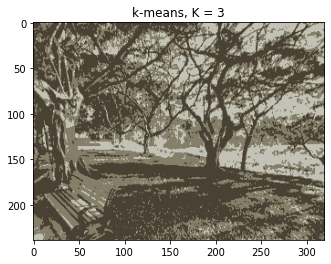

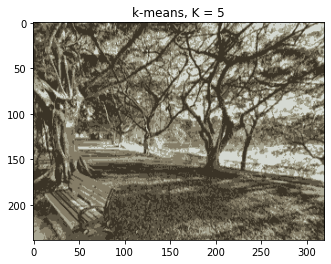

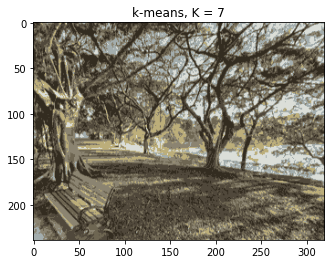

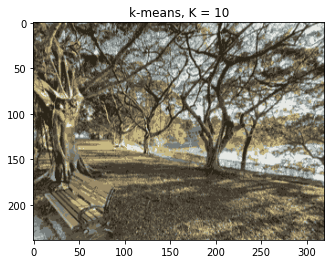

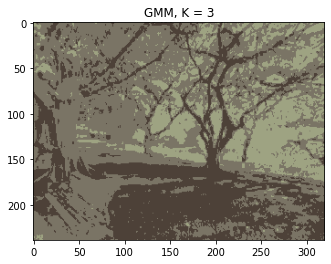

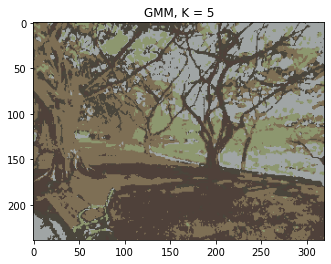

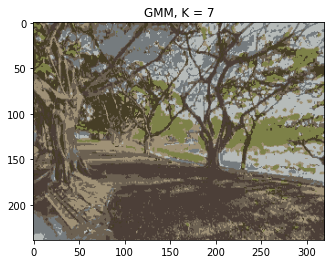

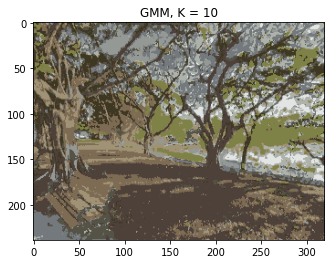

In [17]:
for i in range(4):
  plt.title('k-means, K = ' + str(k_list[i]))
  plt.imshow(k_means_img_list[i])
  plt.show()
for i in range(4):
  plt.title('GMM, K = ' + str(k_list[i]))
  plt.imshow(GMM_img_list[i])
  plt.show()